# Bank Project - Classification Model Fitting

In [1]:
#!pip install imblearn
#!pip install xgboost

In [230]:
import os
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer

import preprocessing as prep

from matplotlib.pyplot import cm
from itertools import cycle
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc, roc_auc_score, precision_recall_fscore_support, precision_score, make_scorer
prec_scorer = make_scorer(precision_score)

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

## Fetch Data

In [231]:
df = pd.read_csv('./data/bank-full.csv', sep=';')

In [232]:
ct = ColumnTransformer(
    [("target",prep.TargetTransformer(),'y')])

y_trans = pd.DataFrame(data = ct.fit_transform(df),columns=['y_trans'] ,index = df.index)

df_t = pd.concat([y_trans,df],axis=1).drop(['y'],axis=1)

In [233]:
train = df_t.sample(n=int(len(df_t)*0.75), random_state=101)
test = df_t[~df_t.index.isin(train.index)]

## Undersamping, Oversampling, & SMOTE Sampling

In [234]:
# Separate majority and minority classes
df_majority = train[train.y_trans==0]
df_minority = train[train.y_trans==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=1)

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([df_majority, df_minority_upsampled])

#
X_train_upsampled = train_upsampled.drop(['y_trans'],axis=1)
y_train_upsampled = train_upsampled.y_trans

# SMOTE Sampling

In [236]:
# SMOTE

sm = SMOTE(sampling_strategy = 0.20, random_state=101)

cat_features = ['job','marital','education','default','housing','loan','contact','poutcome','month']

ct = ColumnTransformer(
    [
    ("logplus1",prep.LogPlus1Transformer(),['duration','age']),
    ("campaign",prep.CampaignTransformer(),'campaign'),
    ("balance",prep.CampaignTransformer(),'balance'),
    ('ohe',OneHotEncoder(sparse=False),cat_features)
    ]
    )

X_smote, y_smote = sm.fit_resample(ct.fit_transform(train.drop(['y_trans'],axis=1)), train.y_trans)

In [237]:
X_train, X_test, y_train, y_test = train.drop(['y_trans'],axis=1), test.drop(['y_trans'],axis=1), train.y_trans, test.y_trans

# Benchmark Model

In [238]:
lreg_smote = LogisticRegression(max_iter=1000).fit(X_smote, y_smote)
precision_recall_fscore_support(y_test, lreg_smote.predict(ct.transform(X_test)))

(array([0.92908701, 0.59657469]),
 array([0.95738265, 0.46307238]),
 array([0.94302262, 0.52141372]),
 array([9949, 1354], dtype=int64))

# Random Forest Model

In [239]:
rtree = RandomForestClassifier()

params = {'n_estimators':[10,50,100],
          'max_depth':[5,10,15,20],
          'min_samples_leaf':[4,10,20],
          'class_weight':['balanced']}

rtree_clf = GridSearchCV(rtree, params)
rtree_clf.fit(X_smote, y_smote)

rtree_clf.score(ct.fit_transform(X_test), y_test)

0.8695921436786693

In [240]:
precision_recall_fscore_support(y_test, rtree_clf.best_estimator_.predict(ct.transform(X_test)))

(array([0.96591534, 0.47282609]),
 array([0.88300332, 0.77104874]),
 array([0.92260029, 0.58618754]),
 array([9949, 1354], dtype=int64))

# Support Vector Machine Model

In [241]:
from sklearn.svm import SVC

model = SVC(gamma='scale', class_weight='balanced')

model.fit(X_smote, y_smote)

model.score(ct.fit_transform(X_test), y_test)

0.8266831814562505

In [242]:
precision_recall_fscore_support(y_test, model.predict(ct.transform(X_test)))

(array([0.97890194, 0.39783857]),
 array([0.82078601, 0.87001477]),
 array([0.89289815, 0.54600232]),
 array([9949, 1354], dtype=int64))

In [243]:
weights = {0:1, 1:2}

model = SVC(gamma='scale', class_weight=weights)

model.fit(X_smote, y_smote)

model.score(ct.fit_transform(X_test), y_test)

0.8852517030876759

In [244]:
precision_recall_fscore_support(y_test, model.predict(ct.transform(X_test)))

(array([0.95768091, 0.51539708]),
 array([0.90984018, 0.70457903]),
 array([0.93314778, 0.59531981]),
 array([9949, 1354], dtype=int64))

# Gradient Boosted Model

In [ ]:
from xgboost import XGBClassifier

params = {'learning_rate':[0.1,0.2,0.3,1],
    'n_estimators':[10,50,100],
          'max_depth':[5,10,20,50],
         'reg_lambda':[1,5,10]}

model = XGBClassifier(scale_pos_weight = 7.2)

xgb = GridSearchCV(model, params)
xgb.fit(X_smote, y_smote)

#xgb = XGBClassifier(scale_pos_weight = 7.2, max_depth = 5, reg_lambda = 10, sampling_method = 'gradient_based')

xgb.score(ct.fit_transform(X_test), y_test)

In [ ]:
precision_recall_fscore_support(y_test, xgb.predict(ct.transform(X_test)))

In [ ]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
# predict probabilities
yhat = xgb.predict_proba(ct.fit_transform(X_test))
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

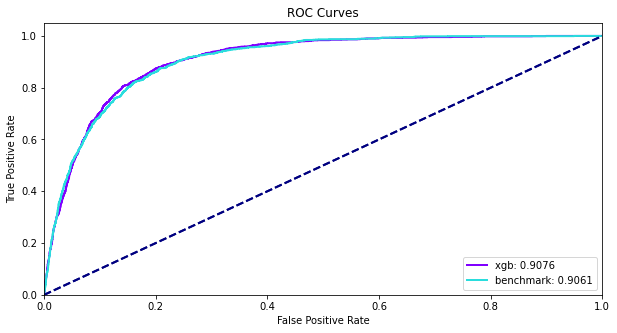

In [224]:
plt.figure(figsize=(10,5))

color=iter(cm.rainbow(np.linspace(0,1,4)))

y_score = xgb.predict_proba(ct.fit_transform(X_test))
y_score_2 = lreg_smote.predict_proba(ct.fit_transform(X_test))

fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color = next(color), label='xgb' + ': %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

fpr, tpr, thresholds = roc_curve(y_test, y_score_2[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color = next(color), label='benchmark' + ': %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [225]:
def precision_recall_fscore_support_thresh(y_true, y_hat_proba, threshold):
    y_hat = [1 if y > threshold else 0 for y in y_hat_proba]
    return(precision_recall_fscore_support(y_true, y_hat))

def pos_class_table(model, y_true, X):
    df = pd.DataFrame(precision_recall_fscore_support(y_true, model.predict(ct.transform(X)))).iloc[:,1]
    return(df)

def score_threshold(model, X_test, y_test, threshold):
    preds = [1 if x > threshold else 0 for x in model.predict_proba(X_test)[:,1]]
    return(accuracy_score(preds,y_test))

In [226]:
precision_recall_fscore_support(y_test, xgb.predict(ct.transform(X_test)))

(array([0.94435937, 0.53647215]),
 array([0.92974168, 0.59748892]),
 array([0.93699352, 0.56533892]),
 array([9949, 1354], dtype=int64))

In [227]:
result_df = pd.DataFrame(data = {
'lreg_smote': pos_class_table(lreg_smote, y_test, X_test),
'xgb_smote': pd.DataFrame(precision_recall_fscore_support_thresh(y_test, xgb.predict_proba(ct.transform(X_test))[:,1],0.71))[1]})
result_df.index = ['precision','recall','f1_score','support']
result_df

,lreg_smote,xgb_smote
precision,0.569510,0.574199
recall,0.532496,0.502954
f1_score,0.550382,0.536220
support,1354.000000,1354.000000


In [228]:
acc_df = pd.DataFrame(data = {
'lreg_smote': lreg_smote.score(ct.transform(X_test), y_test),
'xgb_smote': score_threshold(xgb, ct.transform(X_test), y_test, 0.7)},index = ['accuracy'])
acc_df

,lreg_smote,xgb_smote
accuracy,0.89578,0.895603


In [220]:
print('Ratio of positive class: ' + str(np.round(y_test.value_counts()[1]/len(y_test),2)))
prediction_counts = pd.Series(xgb.predict(X_smote)).value_counts()
print('Ratio of predicted positive class: ' + str(np.round(prediction_counts[1]/prediction_counts[0],2)))

Ratio of positive class: 0.12
Ratio of predicted positive class: 0.25


# END